Постановка задачи

Оценить, есть ли влияние от рекламы чая «Ахмад» в передаче «Что? Где? Когда?» на его продажи.

In [674]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import datetime
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

## Загрузка данных

In [675]:
df = pd.read_csv("data/tea_demand.csv", sep='\t')
df.head()

,brand_id,date,receipts_count
0,5152,2016-07-01,98
1,178,2016-07-01,234
2,29,2016-07-01,622
3,5152,2016-07-02,87
4,178,2016-07-02,185


In [676]:
# Интервал наблюдений
print(df.date.min(), df.date.max())

2016-07-01 2016-11-30


In [677]:
# Дату в индексы
df = df.set_index(pd.to_datetime(df['date']))
df.drop(['date'], axis = 1, inplace = True)
df.head()

,brand_id,receipts_count
date,,
2016-07-01,5152,98
2016-07-01,178,234
2016-07-01,29,622
2016-07-02,5152,87
2016-07-02,178,185


In [678]:
# Разделяем по брендам
df_ah = df[df.brand_id==178]['receipts_count']
df_li = df[df.brand_id==29]['receipts_count']
df_ma = df[df.brand_id==5152]['receipts_count']

In [679]:
# проверка размера
df_ah.shape[0]+df_li.shape[0]+df_ma.shape[0] == df.shape[0]

True

## Парсинг

In [680]:
url = 'https://chgk.tvigra.ru/letopis/?2016' # Определяем значение URL страницы для запроса
response = requests.get(url)

In [681]:
soup = BeautifulSoup(response.text,'html.parser')
table = soup.find_all('table', class_='txt')[0]
list_date = table.find_all('tr')[1].get_text()

In [682]:
# запись дат передач в список
list_date = []

for i in table.find_all('tr')[1].select('li'):
    date_string = i.find('a').attrs['href'][-5:]+'2016'
    x = datetime.datetime.strptime(date_string,'%d%b%Y')
    list_date.append(x)

In [683]:
# второй список с датами передачи и два дня после
list_date2 = []

for i in list_date:
    list_date2.append(i)
    list_date2.append(i+datetime.timedelta(days=1))
    list_date2.append(i+datetime.timedelta(days=2))

In [684]:
# только дата
for i in range(0, len(list_date2)):
    list_date2[i] = list_date2[i].date()

## Статистические методы

In [685]:
iqr = np.percentile(df_ah, 75) - np.percentile(df_ah, 25)
c = df_ah[(df_ah<(np.percentile(df_ah, 25) - 1.5*iqr))|(df_ah>(np.percentile(df_ah, 75) + 1.5*iqr))]
print(c)

date
2016-10-31    677
2016-11-09    708
2016-11-10    712
Name: receipts_count, dtype: int64


С использованием статистического метода аномалии найдены, но к датам проведения игр отношения не имеют - ближайшая дата аномалии расположена через 8 дней после игры.

## Предсказания продаж

### Ahmad

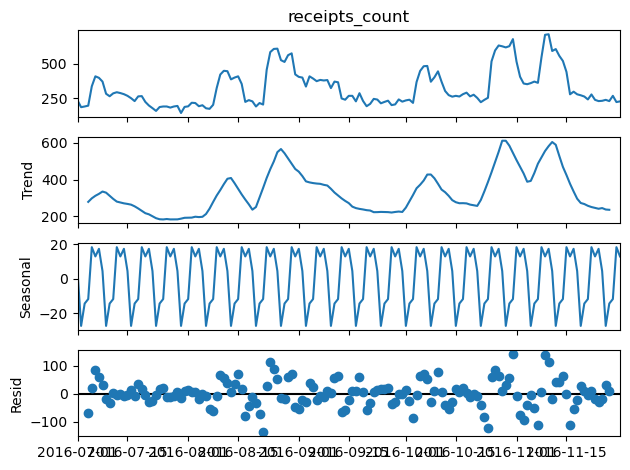

In [686]:
decomposition = seasonal_decompose(df_ah.fillna(df_ah.mean()), model='additive') 
decomposition.plot()
pyplot.show()

In [687]:
test = adfuller(df_ah.diff().dropna())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -6.874263180315061
p-value:  1.4884446590032864e-09
Critical values:  {'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}
ряд стационарен


Ряд стационарен после 1 diff.

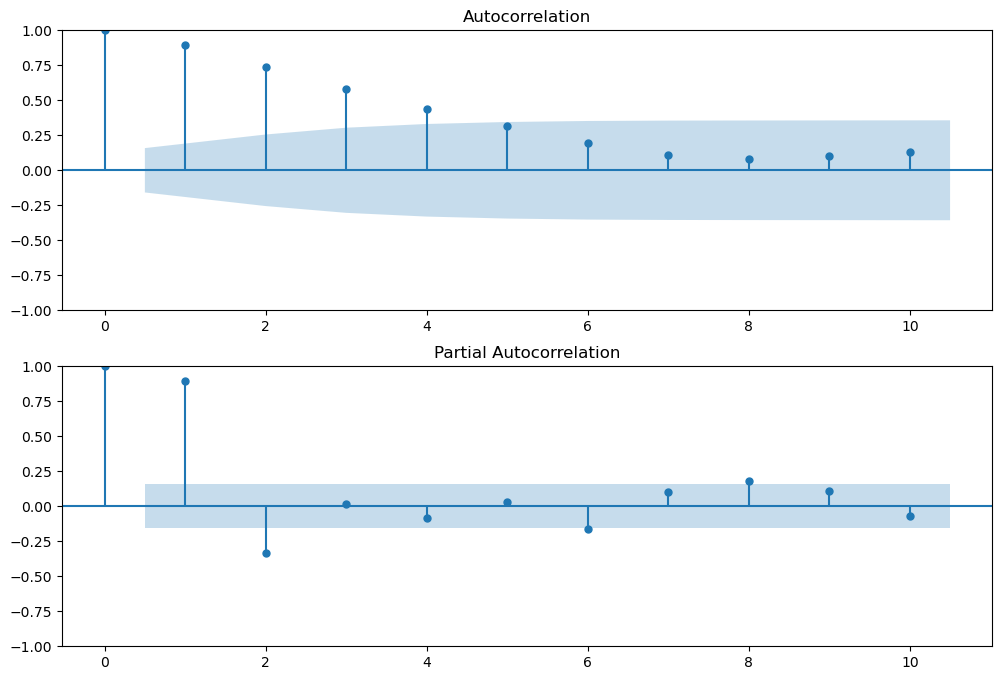

In [688]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_ah, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_ah, lags=10, ax=ax2)

In [689]:
model = pm.auto_arima(
    df_ah,
    start_p=1,
    d=1,
    start_q=1,
    max_p=8,
    max_q=5,
    start_D=0,
    start_P=0,
    start_Q=0,
    m=14,
    test="adf",
    error_action="ignore",
    random_state=1
)

arima_predictions = model.predict()

In [690]:
model = ARIMA(df_ah.values.reshape(-1), order=(8,1,4))

train_size = len(df_ah)
arima_predictions2 = model.fit().predict(start=train_size,end=train_size+14,  dynamic=False)

c:\Users\anzel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [691]:
index_ = [pd.Timestamp('11-30-2016'), pd.Timestamp('12-01-2016'), pd.Timestamp('12-02-2016'),
          pd.Timestamp('12-03-2016'), pd.Timestamp('12-04-2016'), pd.Timestamp('12-05-2016'),
          pd.Timestamp('12-06-2016'), pd.Timestamp('12-07-2016'), pd.Timestamp('12-08-2016'),
          pd.Timestamp('12-09-2016'), pd.Timestamp('12-10-2016'), pd.Timestamp('12-11-2016'),
          pd.Timestamp('12-12-2016'), pd.Timestamp('12-13-2016'), pd.Timestamp('12-14-2016'),]
arima_predictions2 = pd.Series(arima_predictions2, index=index_)

In [692]:
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df_ah.index, y=df_ah, name='Original'))
fig.add_trace(go.Scatter(x=arima_predictions.index, y=arima_predictions, name='Predictions'))
fig.add_trace(go.Scatter(x=arima_predictions2.index, y=arima_predictions2, name='Predictions_ARIMA'))

for i in list_date:
    if (i>df_ah.index[0])&(i<index_[-1]):
        fig.add_vline(x=i)
    else:
        continue

fig.update_layout(
    margin=dict(l=15, r=15, t=40, b=15),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show()

На графике видно что изменение тренда продаж начинается до игры и заканчивается после, а значит игра не имеет влияния на продажы чая Ahmad. По предсказаниям в одном случае продажи после растут, а во втором снижаются, думаю это тоже свидетельствует об отсутствии влияния.

С другой стороны такая ситуация наблюдается осенью, зимой(и в конце ноября) есть небольшой подъем продаж, по предсказаниям так же наблюдается небольшой подъем. Может потому что чай более востребован в холодное время года?:)

### Lipton

In [693]:
test = adfuller(df_li)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -3.044005580472901
p-value:  0.0309842238093317
Critical values:  {'1%': -3.4744158894942156, '5%': -2.880878382771059, '10%': -2.577081275821236}
ряд стационарен


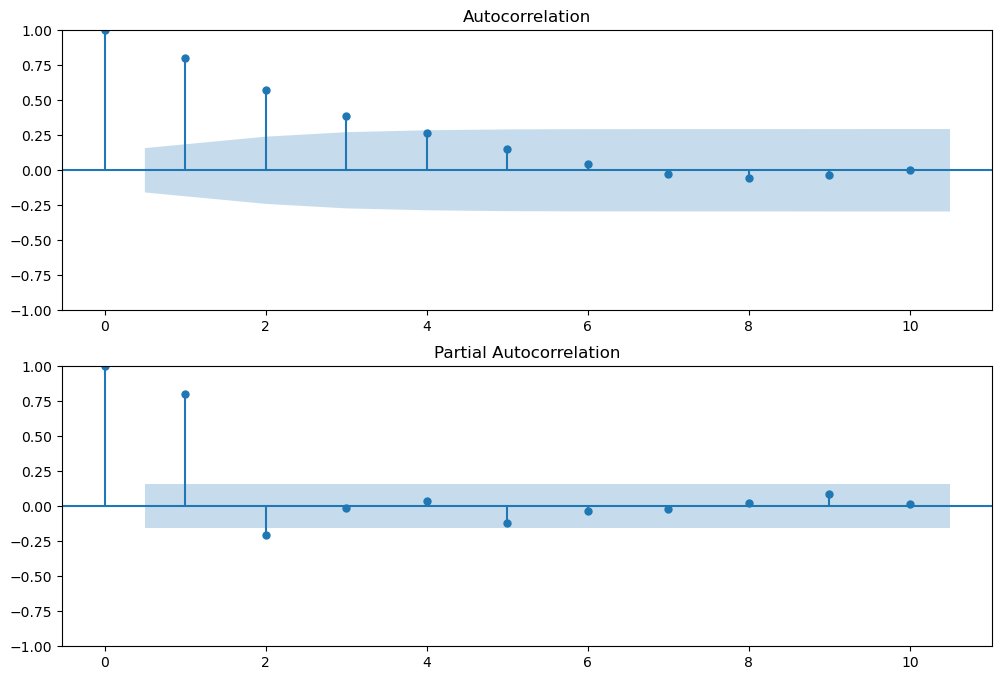

In [694]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_li, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_li, lags=10, ax=ax2)

In [695]:
model = pm.auto_arima(
    df_ah,
    start_p=1,
    d=0,
    start_q=1,
    max_p=8,
    max_q=8,
    start_D=0,
    start_P=0,
    start_Q=0,
    m=14,
    test="adf",
    error_action="ignore",
    random_state=1
)

arima_predictions = model.predict()

model = ARIMA(df_li.values.reshape(-1), order=(2,0,4))

train_size = len(df_li)
arima_predictions2 = model.fit().predict(start=train_size,end=train_size+14,  dynamic=False)

arima_predictions2 = pd.Series(arima_predictions2, index=index_)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df_li.index, y=df_li, name='Original'))
fig.add_trace(go.Scatter(x=arima_predictions.index, y=arima_predictions, name='Predictions'))
fig.add_trace(go.Scatter(x=arima_predictions2.index, y=arima_predictions2, name='Predictions_ARIMA'))

for i in list_date:
    if (i>df_ah.index[0])&(i<index_[-1]):
        fig.add_vline(x=i)
    else:
        continue

fig.update_layout(
    margin=dict(l=15, r=15, t=40, b=15),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show()

c:\Users\anzel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



У Липтона взаимосвязи не наблюдаю. Разве что 2 последние игры, но одна из них предсказанная, не уверена что можно брать эти факты во внимание.

### May

In [696]:
test = adfuller(df_ma.diff().dropna())
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -5.929372822673358
p-value:  2.400856015479221e-07
Critical values:  {'1%': -3.4756368462466662, '5%': -2.8814104466172608, '10%': -2.5773652982553568}
ряд стационарен


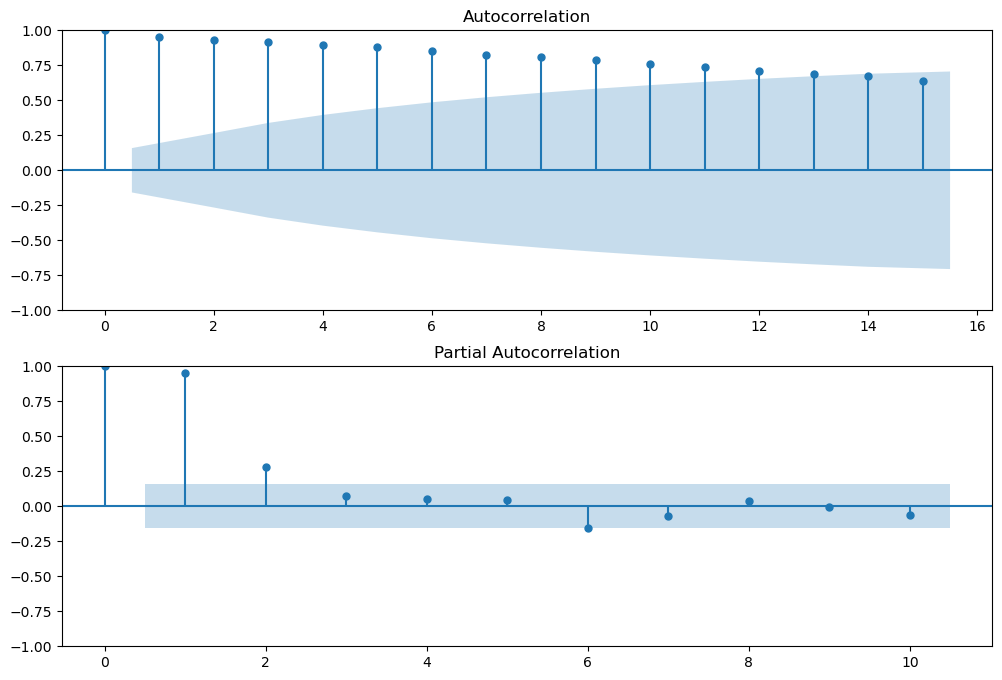

In [697]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_ma, lags=15, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_ma, lags=10, ax=ax2)

In [698]:
model = pm.auto_arima(
    df_ma,
    start_p=1,
    d=1,
    start_q=1,
    max_p=8,
    max_q=14,
    start_D=0,
    start_P=0,
    start_Q=0,
    m=14,
    test="adf",
    error_action="ignore",
    random_state=1
)

arima_predictions = model.predict()

model = ARIMA(df_ma.values.reshape(-1), order=(6,1,12))

train_size = len(df_ma)
arima_predictions2 = model.fit().predict(start=train_size,end=train_size+14,  dynamic=False)

arima_predictions2 = pd.Series(arima_predictions2, index=index_)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df_ma.index, y=df_ma, name='Original'))
fig.add_trace(go.Scatter(x=arima_predictions.index, y=arima_predictions, name='Predictions'))
fig.add_trace(go.Scatter(x=arima_predictions2.index, y=arima_predictions2, name='Predictions_ARIMA'))

for i in list_date:
    if (i>df_ah.index[0])&(i<index_[-1]):
        fig.add_vline(x=i)
    else:
        continue

fig.update_layout(
    margin=dict(l=15, r=15, t=40, b=15),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show()

c:\Users\anzel\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Boxplot

In [699]:
px.box(df_ah)

In [700]:
px.box(df_li)

In [701]:
px.box(df_ma)

Не очень понимаю что в контексте данного задания можно здесь увидеть... аномалии... да, они есть.

## Кластеризация

In [702]:
# функция для добавления маркеров игры и лаг
def app_game(df_clust):
    df_clust['game'] = 0
    for n, i in enumerate(df_clust.index.date):
        for j in list_date2:
            if i==j:
                df_clust.iloc[n, 2]=1
                break
            else:
                continue
    df_clust["shift2"] = df_clust["receipts_count"].shift(2)
    df_clust["shift3"] = df_clust["shift2"].shift()
    df_clust["shift4"] = df_clust["shift3"].shift()
    df_clust["shift5"] = df_clust["shift4"].shift()
    df_clust["shift6"] = df_clust["shift5"].shift()
    df_clust["shift7"] = df_clust["shift6"].shift()
    df_clust["shift8"] = df_clust["shift7"].shift()
    df_clust.dropna(inplace=True)
    return df_clust

In [703]:
# применение функции к таблицам
df_ah_clust = app_game(df[df.brand_id==178])
df_li_clust = app_game(df[df.brand_id==29])
df_ma_clust = app_game(df[df.brand_id==5152])

C:\Users\anzel\AppData\Local\Temp\ipykernel_16936\2123543333.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anzel\AppData\Local\Temp\ipykernel_16936\2123543333.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\anzel\AppData\Local\Temp\ipykernel_16936\2123543333.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [704]:
# объединение таблиц
df_clust = pd.concat([df_ah_clust, df_li_clust, df_ma_clust])

### Kmeans

In [705]:
# Нормализуем наши данные
starrd_scaler = preprocessing.StandardScaler().fit(df_clust)
np_scaled = starrd_scaler.transform(df_clust)
data = pd.DataFrame(np_scaled)

# Уменьшим количество компонент
pca = PCA(n_components=2)
data = pca.fit_transform(data)

min_max_scaler = preprocessing.StandardScaler().fit(data)
np_scaled = min_max_scaler.transform(data)
data = pd.DataFrame(np_scaled)

In [706]:
kmeans = KMeans(n_clusters=4).fit(data)

df_clust['cluster'] = kmeans.predict(data)
df_clust['principal_feature1'] = data[0].values
df_clust['principal_feature2'] = data[1].values
df_clust['cluster'].value_counts()

c:\Users\anzel\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



cluster
0    135
3    121
1    116
2     63
Name: count, dtype: int64

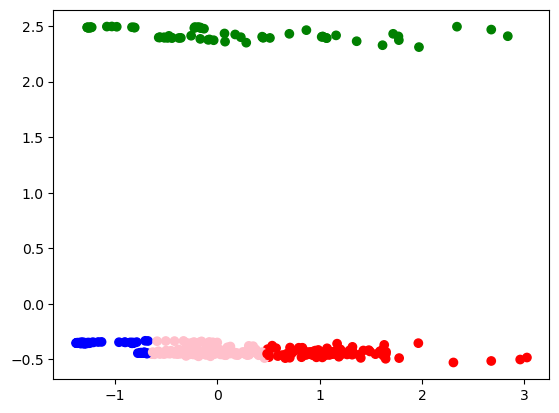

In [707]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df_clust['principal_feature1'], df_clust['principal_feature2'], c=df_clust["cluster"].apply(lambda x: colors[x]))
plt.show()

In [708]:
def getDistanceByPoint(data, model):
    # Расчет расстояний от точек до центров кластеров
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    distance = pd.Series(distance)    
    return distance

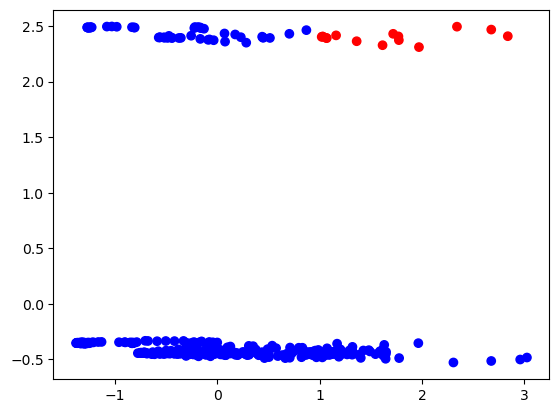

In [709]:
outliers_fraction = 0.01
distance = getDistanceByPoint(data, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

# Считаем точку аномалией, если расстояние до центра кластера больше порога
df_clust['anomaly'] = (distance.values >= 3.5).astype(int)

fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df_clust['principal_feature1'], df_clust['principal_feature2'], c=df_clust["anomaly"].apply(lambda x: colors[x]))
plt.show()

### DBSCAN

In [710]:
dbscan = DBSCAN(eps=2, min_samples=5)

In [711]:
df_clust['prediction_dbscan_1'] = dbscan.fit_predict(df_clust['receipts_count'].values.reshape(-1, 1))

In [712]:
# Обнаруженные аномалии
df_anomal = df_clust[(df_clust.prediction_dbscan_1 < 0)&(df_clust.brand_id==178)]
df_anomal.shape

(55, 15)

In [713]:
#fig = make_subplots(rows=1, cols=1)
fig = px.scatter(x=df_anomal.index, y=df_anomal.receipts_count)
fig.add_trace(go.Scatter(x=df_ah.index, y=df_ah, name='Original'))

for i in list_date:
    if (i>df_ah.index[0])&(i<index_[-1]):
        fig.add_vline(x=i)
    else:
        continue

fig.update_layout(
    margin=dict(l=15, r=15, t=40, b=15),
    paper_bgcolor='LightSteelBlue',
    showlegend=True
)

fig.show()

## Вывод

Я не выявила влияния рекламы чая Ahmad в передаче «Что? Где? Когда?» на его продажи. Аномальные значения присутствуют, в основном это аномально высокие значения, но с датами проведения передачи эти аномалии не связаны.